In [1]:
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import math
from sklearn.neural_network import MLPClassifier
from sklearn import preprocessing
from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPClassifier
import random
from scipy.stats import norm
import seaborn as sns
import matplotlib.tri as tri

In [2]:
def split(dataset, labelCol):
    
    training = []
    validation = []
    
    dataset = dataset[dataset[:,labelCol].argsort()]
    
    for i in range(len(dataset)):
        
        if i % 10 == 0:
            validation.append(dataset[i])
        
        else:
            training.append(dataset[i])
    
    return np.asarray(training), np.asarray(validation)

In [3]:
#2D Potential

x1 = 0.5
y1 = 0.5

x2 = -0.5
y2 = -0.5

W = 0.0001
sigma = 0.4

factor = 2

def gaussian(x, xo):
    
    g = math.exp(-1 * math.pow((x - xo), 2)/(2 * math.pow(sigma,2)))
    
    return g

def twoDpotential(x,y):
    
    V = W * (math.pow(x,6) + math.pow(y,6)) - factor * (gaussian(x, x1) * gaussian(y, y1)) \
        - factor * (gaussian(x, x2) * gaussian(y, y2)) 
    
    return V

def accX(x,y,vX):
    
    acc = W * (6 * math.pow(x,5)) \
            - factor * gaussian(y, y1) * gaussian(x, x1) * (-1 * 2 * (x - x1) / (2 * math.pow(sigma,2))) \
            - factor * gaussian(y, y2) * gaussian(x, x2) * (-1 * 2 * (x - x2) / (2 * math.pow(sigma,2)))
    
    return (-1 * acc)

def accY(x,y,vY):
    
    acc = W * (6 * math.pow(y,5)) \
            - factor * gaussian(y, y1) * gaussian(x, x1) * (-1 * 2 * (y - y1) / (2 * math.pow(sigma,2))) \
            - factor * gaussian(y, y2) * gaussian(x, x2) * (-1 * 2 * (y - y2) / (2 * math.pow(sigma,2)))
    
    return (-1 * acc)

def run_2D_md(dt, number_of_steps, temp, coord):
    """
    Run a MD simulation.
    
    Parameters
    ----------
    dt: float
        The timestep length (s)
    number_of_steps: int
        Number of iterations in the simulation
    initial_temp: float
        Temperature of the system at 
        initialisation (K)
    x: ndarray of floats
        The initial positions of the particles in a 
        single dimension (Å)
        
    Returns
    -------
    ndarray of floats
        The positions for all of the particles 
        throughout the simulation (Å)
    """
#    positions = np.zeros((number_of_steps, len(x)))
    positionsX = []
    positionsY = []
    positionsX.append(coord[0])
    positionsY.append(coord[1])
    
    x = coord[0]
    y = coord[1]
    
    vX = np.random.uniform(-1 * temp, temp)
    vY = np.random.uniform(-1 * temp, temp)
    aX = accX(x,y,vX)
    aY = accY(x,y,vY)

    for i in range(number_of_steps):
        x = update_pos(x, vX, aX, dt)
        y = update_pos(y, vY, aY, dt)
        a1X = accX(x,y,vX)
        a1Y = accY(x,y,vY)
        vX = update_velo(vX, aX, a1X, dt)
        vY = update_velo(vY, aY, a1Y, dt)
        aX = np.array(a1X)
        aY = np.array(a1Y)
        positionsX.append(x)
        positionsY.append(y)
#        print(x,y,vX,vY,aX,aY,i)
#        positions[i, :] = x
    return positionsX, positionsY

In [4]:
#this is step A
def position_update(x,v,dt):
    x_new = x + v*dt/2.
    return x_new

#this is step B
def velocity_update(v,F,dt):
    v_new = v + F*dt/2.
    return v_new

def random_velocity_update(v,gamma,kBT,dt):
    R = np.random.normal()
    c1 = np.exp(-gamma*dt)
    c2 = np.sqrt(1-c1*c1)*np.sqrt(kBT)
    v_new = c1*v + R*c2
    return v_new

def baoab(potential, max_time, dt, gamma, kBT, initial_position, initial_velocity,
                                        save_frequency=5, **kwargs ):
    x = initial_position[0]
    y = initial_position[1]
    vx = initial_velocity[0]
    vy = initial_velocity[1]

    t = 0
    step_number = 0
    
    positions = []
    velocities = []
    
    total_energies = []
    save_times = []
    
    while(t<max_time):
        
        # B
        potential_energy = potential(x,y,**kwargs)
        forceX = accX(x,y,vx)
        forceY = accY(x,y,vy)
        
        vx = velocity_update(vx,forceX,dt)
        vy = velocity_update(vy,forceY,dt)
        
        #A
        x = position_update(x,vx,dt)
        y = position_update(y,vy,dt)

        #O
        vx = random_velocity_update(vx,gamma,kBT,dt)
        vy = random_velocity_update(vy,gamma,kBT,dt)

        #A
        x = position_update(x,vx,dt)
        y = position_update(y,vy,dt)
        
        # B
        potential_energy = twoDpotential(x,y,**kwargs)
        forceX = accX(x,y,vx)
        forceX = accY(x,y,vy)
        
        vx = velocity_update(vx,forceX,dt)
        vy = velocity_update(vy,forceY,dt)

        if step_number%save_frequency == 0 and step_number>0:
            ke = .5*(vx*vx + vy*vy)
            pe = potential_energy

            positions.append([x,y])
            velocities.append([vx,vy])
            total_energies.append([ke,pe,ke+pe])
            save_times.append(t)
        
        if t % (500) < 0.01:
            print("Currently at t = " + str(t))
        
        t = t+dt
        step_number = step_number + 1
    
    return save_times, positions, velocities, total_energies   

Initial Coordinates = -0.16059214762654894, 0.20909866918452102
Initial Velocities = -0.32010597923991124, 0.24031071447617242
Initial Kinetic Energy = 0.08010853871859547
Initial Potential energy = -0.6825046196448417
Initial Total energy = -0.6023960809262462
Currently at t = 0
Currently at t = 500.00999999969025
Currently at t = 1000.0099999992356
Currently at t = 1500.0099999987808
Currently at t = 2000.009999998326
Currently at t = 2500.0000000081486
Currently at t = 3000.0000000190626
Currently at t = 3500.0000000299765
Currently at t = 4000.0000000408904
Currently at t = 4500.000000051804
Currently at t = 5000.000000062718
Currently at t = 5500.000000073632
Currently at t = 6000.000000084546
Currently at t = 6500.00000009546
Currently at t = 7000.000000106374
Currently at t = 7500.0000001172875
Currently at t = 8000.0000001282015
Currently at t = 8500.000000139114
Currently at t = 9000.000000150028
Currently at t = 9500.000000160942
Currently at t = 10000.000000171856
Currently 

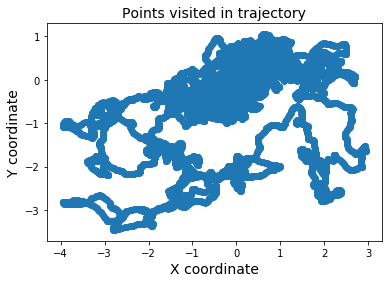

In [5]:
my_max_time = 20000

x = np.random.uniform(-0.5,0.5)
y = np.random.uniform(-0.5,0.5)

vx = np.random.normal(0,0.3)
vy = np.random.normal(0,0.3)

initial_position = [x,y]
initial_velocity = [vx,vy]

my_gamma = 3
my_kBT=(1/9.5)
my_dt=0.01

KE = 0.5 * (vx * vx + vy * vy)
PE = twoDpotential(x,y)

print("Initial Coordinates = " + str(x) + ", " + str(y))
print("Initial Velocities = " + str(vx) + ", " + str(vy))
print("Initial Kinetic Energy = " + str(KE))

print("Initial Potential energy = " + str(PE))

print("Initial Total energy = " + str(PE + KE))


times, positions, velocities, total_energies = baoab(twoDpotential, \
                                                    my_max_time, my_dt, my_gamma, my_kBT, \
                                                    initial_position, initial_velocity,\
                                                    )



times = np.asarray(times)
positions = np.asarray(positions)
velocities = np.asarray(velocities)
total_energies = np.asarray(total_energies)


plt.title('Points visited in trajectory', size=14)
plt.xlabel('X coordinate', size=14)
plt.ylabel('Y coordinate', size=14)
plt.scatter(positions[:,0], positions[:,1])
plt.savefig('toyModel/2DlangevinNtransitions/trajectory.png')

In [6]:
print("Average Kinetic Energy = " + str(total_energies[:,0].mean()))
print("kBT = ", my_kBT)
print("Average Potential Energy = " + str(total_energies[:,1].mean()))
print("Average Total Energy = " + str(total_energies[:,2].mean()))

Average Kinetic Energy = 0.11692040301018473
kBT =  0.10526315789473684
Average Potential Energy = -1.7612559809659378
Average Total Energy = -1.6443355779557536


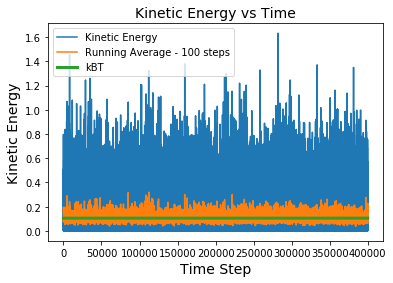

In [7]:
def movingaverage(interval, window_size):
    window= np.ones(int(window_size))/float(window_size)
    return np.convolve(interval, window, 'same')

window_size = 100
ke_av = movingaverage(total_energies[:,0], window_size)

plt.title('Kinetic Energy vs Time', size=14)
plt.plot(total_energies[:,0], label = 'Kinetic Energy')
plt.plot(ke_av, label='Running Average - ' + str(window_size) + ' steps')
plt.plot([my_kBT]*len(total_energies[:,0]), linewidth=3.0, label='kBT')
plt.legend(loc='upper left')
plt.xlabel('Time Step', size=14)
plt.ylabel('Kinetic Energy', size=14)
plt.savefig('toyModel/2DlangevinNtransitions/KE.png')


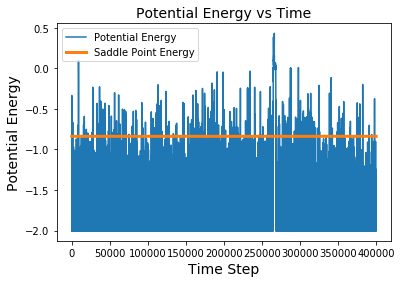

In [8]:
plt.title('Potential Energy vs Time', size=14)
plt.plot(total_energies[:,1], label = 'Potential Energy')
plt.plot([twoDpotential(0,0)]*len(total_energies[:,0]), linewidth=3.0, label='Saddle Point Energy')
plt.legend(loc='upper left')
plt.xlabel('Time Step', size=14)
plt.ylabel('Potential Energy', size=14)
plt.savefig('toyModel/2DlangevinNtransitions/PE.png')


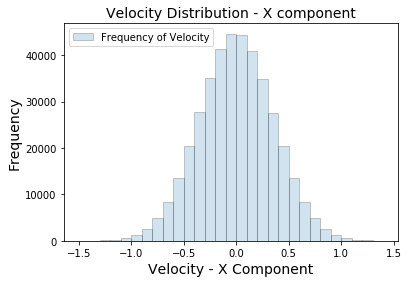

In [9]:
plt.title('Velocity Distribution - X component', size=14)
plt.xlabel('Velocity - X Component', size=14)
plt.ylabel('Frequency', size=14)
bins_list = np.arange(-1.5,1.5,0.1)
plt.hist(velocities[:,0], edgecolor='k', alpha=0.2, bins=bins_list,label='Frequency of Velocity')
plt.legend(loc='upper left')
plt.savefig('toyModel/2DlangevinNtransitions/velocityX.png')

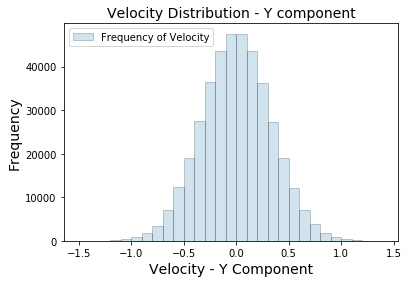

In [10]:
plt.title('Velocity Distribution - Y component', size=14)
plt.xlabel('Velocity - Y Component', size=14)
plt.ylabel('Frequency', size=14)
bins_list = np.arange(-1.5,1.5,0.1)
plt.hist(velocities[:,1], edgecolor='k', alpha=0.2, bins=bins_list,label='Frequency of Velocity')
plt.legend(loc='upper left')
plt.savefig('toyModel/2DlangevinNtransitions/velocityY.png')

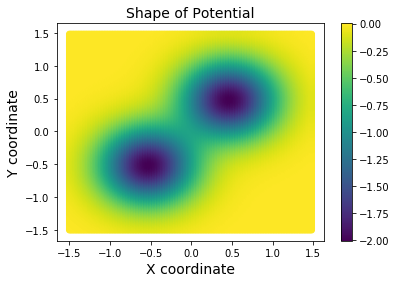

In [11]:
a = np.arange(x2-1,x1+1,0.02)
b = np.arange(y2-1,y1+1,0.02)

potential = []

for x in a:
    for y in b:
        
        potential.append([x,y,twoDpotential(x,y)])

potential = np.asarray(potential)

plt.title('Shape of Potential', size=14)
plt.xlabel('X coordinate', size=14)
plt.ylabel('Y coordinate', size=14)
plt.scatter(potential[:,0],potential[:,1],c=potential[:,2])
# plt.tricontour(potential[:,0],potential[:,1],potential[:,2],500)
plt.colorbar()
plt.savefig('toyModel/2DlangevinNtransitions/potential.png')

In [12]:
positionsX = positions[:,0]
positionsY = positions[:,1]
velocitiesX = velocities[:,0]
velocitiesY = velocities[:,1]

min1 = twoDpotential(x1,y1)
min2 = twoDpotential(x2,y2)

width = my_kBT

data = np.vstack((positionsX,positionsY,velocitiesX,velocitiesY)).T

dataset = []
nextState = [-1, -1]

nTransitions = -1
prevState = -1

tTransitions = []

for i in range(len(data)):
    
    if i % 9999 == 0:
        print("Finished step: " + str(i+1) + " of " + str(len(data)))
    
    x = data[i][0]
    y = data[i][1]
    velX = data[i][2]
    velY = data[i][3]

    if i < nextState[0]:
        dataset.append([x, y, velX, velY, nextState[1]])
        continue
        
    currPotential = twoDpotential(x,y)

    dist1 = np.sqrt(math.pow(x-x1,2) + math.pow(y-y1,2))
    dist2 = np.sqrt(math.pow(x-x2,2) + math.pow(y-y2,2))
#     if np.sqrt(math.pow(x-x1,2) + math.pow(y-y1,2)) < width:
    if currPotential - min1 < width and dist1 < dist2:
        dataset.append([x, y, velX, velY, 1])
        continue
    
#     if np.sqrt(math.pow(x-x2,2) + math.pow(y-y2,2)) < width:
    if currPotential - min2 < width and dist2 < dist1:
        dataset.append([x, y, velX, velY, 0])
        continue
            
    for j in range(i, len(data)):
        
        xj = data[j][0]
        yj = data[j][1]
        
        if np.sqrt(math.pow(xj - x1,2) + math.pow(yj - y1,2)) < width:
            dataset.append([x, y, velX, velY, 1])
            nextState = [j,1]
            
            if nTransitions == -1:
                prevState = 1
                nTransitions += 1

            else:
                if prevState != 1:
                    nTransitions += 1
                    prevState = 1
                    tTransitions.append(j)
            break

        if np.sqrt(math.pow(xj - x2,2) + math.pow(yj - y2,2)) < width:
            
            dataset.append([x, y, velX, velY, 1])
            nextState = [j,0]
            
            if nTransitions == -1:
                prevState = 2
                nTransitions += 1
                
            else:
                if prevState != 2:
                    nTransitions += 1
                    prevState = 2
                    tTransitions.append(j)
            break

dataset = np.asarray(dataset)
unique, counts = np.unique(dataset[:,4], return_counts = True)
print(unique, counts)

Finished step: 1 of 400000
Finished step: 10000 of 400000
Finished step: 19999 of 400000
Finished step: 29998 of 400000
Finished step: 39997 of 400000
Finished step: 49996 of 400000
Finished step: 59995 of 400000
Finished step: 69994 of 400000
Finished step: 79993 of 400000
Finished step: 89992 of 400000
Finished step: 99991 of 400000
Finished step: 109990 of 400000
Finished step: 119989 of 400000
Finished step: 129988 of 400000
Finished step: 139987 of 400000
Finished step: 149986 of 400000
Finished step: 159985 of 400000
Finished step: 169984 of 400000
Finished step: 179983 of 400000
Finished step: 189982 of 400000
Finished step: 199981 of 400000
Finished step: 209980 of 400000
Finished step: 219979 of 400000
Finished step: 229978 of 400000
Finished step: 239977 of 400000
Finished step: 249976 of 400000
Finished step: 259975 of 400000
Finished step: 269974 of 400000
Finished step: 279973 of 400000
Finished step: 289972 of 400000
Finished step: 299971 of 400000
Finished step: 309970 o

In [13]:
fullDataset = np.copy(dataset)

In [14]:
print(nTransitions)
print(tTransitions)

27
[27633, 52025, 66741, 70434, 85207, 111317, 125015, 137257, 159051, 171766, 180458, 187431, 197674, 198836, 213485, 216508, 221664, 234192, 240387, 258449, 268195, 300797, 310996, 313999, 315678, 319636, 357417]


In [15]:
accuracies = []

for i in range(19):

    print(i)
    dataset = fullDataset[:tTransitions[i]]
    text = 'nTransitions = ' + str(nTransitions)
    df = pd.DataFrame(dataset, columns = ['X Coordinate','Y Coordinate','velX','velY','endState'])
    
    plt.figure()
    sns.scatterplot(data=df, x='X Coordinate', y='Y Coordinate', hue='endState')
    plt.legend(fontsize=14)
    plt.title('End states - ' + str(i+2) + ' Transitions', size=14)
    plt.savefig('toyModel/2DlangevinNtransitions/endState' + str(i+2) + '.png')
    plt.close()
    
    dataset = np.asarray(dataset)

    labelCol = len(dataset[0]) - 1
    training, validation = split(dataset, labelCol)

    trainInputs = training[:,:labelCol]
    trainLabels = training[:,labelCol]
    validInputs = validation[:,:labelCol]
    validLabels = validation[:,labelCol]

    scaler = preprocessing.StandardScaler().fit(trainInputs)

    clf = MLPClassifier(hidden_layer_sizes=[8,4], alpha=0.001,\
                        max_iter = 1000, solver='adam')

    clf.fit(scaler.transform(trainInputs), trainLabels)
    
    accuracies.append([clf.score(scaler.transform(trainInputs), trainLabels),\
                      clf.score(scaler.transform(validInputs), validLabels)])    

    
    trials = 500
    batch_size = 10000

    meanX,stdX=norm.fit(velocities[:,0])
    meanY,stdY=norm.fit(velocities[:,1])

#     print("Started predictions")

    committor = np.asarray([0,0,0])

    for k in range(0,len(dataset[:,0])+1,batch_size):

        committorTemp = np.zeros((batch_size,3))

        xarray = np.repeat(dataset[k:k+batch_size,0], repeats=trials, axis=0)
        yarray = np.repeat(dataset[k:k+batch_size,1], repeats=trials, axis=0)

        velX = np.random.normal(meanX, stdX, len(xarray))
        velY = np.random.normal(meanY, stdY, len(yarray))

        toPred = np.vstack((xarray,yarray,velX,velY)).T
        toPred = scaler.transform(toPred)
        preds = clf.predict(toPred)    

        for j in range(0, batch_size):

            if k+j >= len(dataset):
                committorTemp = committorTemp[:j]
                break
            predictions = preds[j*trials:(j+1)*trials]
            unique, count = np.unique(predictions, return_counts=True)
            if len(unique) == 1:        
                if unique == 0:
                    counts = [count[0], 0]

                else:
                    counts = [0, count[0]]
            else:

                counts = count

            counts = np.asarray(counts)/trials
            committorTemp[j] = [dataset[k+j][0],dataset[k+j][1],counts[1]]


#             if int(k+j+1) % 10000 == 0:
#                 print("Finished step " + str(k+j+1) + " of " + str(len(dataset)))

        committor = np.vstack((committor,committorTemp))
#         print(committor.shape)

    committor = committor[1:]

    x = committor[:,0]
    y = committor[:,1]
    z = committor[:,2]
    
    plt.figure()
    plt.title("Committor probability - " + str(i+2) + " transitions", size=14)
    plt.xlabel('X coordinate', size=14)
    plt.ylabel('Y coordinate', size=14)
    plt.scatter(x,y,c=z)
    plt.colorbar()
    plt.savefig("toyModel/2DlangevinNtransitions/CommProb" + str(i+2) + ".png")
    plt.close()
    
    deviation = 0.05

    transitionPts = committor[np.logical_and(committor[:,2] > (0.5 - deviation), \
                             committor[:,2] < (0.5 + deviation))]

    minPotential = potential[:,2].min()

    transitionPts = np.asarray(transitionPts)
    plt.figure()
    plt.title("Transition States - " + str(i+2) + " transitions", size=14)
    plt.xlabel("X Coordinate", size=14)
    plt.ylabel("Y Coordinate", size=14)
    plt.scatter(transitionPts[:,0],transitionPts[:,1])
    plt.tricontour(potential[:,0],potential[:,1],(potential[:,2] - minPotential)/my_kBT, 15)
    plt.colorbar(label='Minima + n * kBT')
    plt.savefig("toyModel/2DlangevinNtransitions/TS" + str(i+2) + ".png")
    plt.close()

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18


In [30]:
# space=[
#     Categorical(['tanh','relu'],name='activation'),
#     Integer(2,16,name='hiddenLayer1'),
#     Integer(2,16,name='hiddenLayer2'),
#     Integer(2,16,name='hiddenLayer3'),
#     Real(1e-3,1e-1,name='learning_rate_init')
#     ]


In [34]:
# from sklearn.neural_network import MLPClassifier
# from sklearn import preprocessing
# from skopt.space import Real, Integer, Categorical 
# from skopt.utils import use_named_args
# from skopt import gp_minimize

# space=[
#     Categorical(['tanh','relu'],name='activation'),
#     Integer(2,16,name='hiddenLayer1'),
#     Integer(2,16,name='hiddenLayer2'),
#     Integer(2,16,name='hiddenLayer3'),
#     Real(1e-3,1e-1,name='learning_rate_init')
#     ]

# dataset = np.asarray(dataset)

# labelCol = len(dataset[0]) - 1
# training, validation = split(dataset, labelCol)

# trainInputs = training[:,:labelCol]
# trainLabels = training[:,labelCol]
# validInputs = validation[:,:labelCol]
# validLabels = validation[:,labelCol]

# # scaler = preprocessing.StandardScaler().fit(trainInputs)

# clf = MLPClassifier(max_iter = 1000, solver='adam', random_state=31)


# @use_named_args(space)

# def objective(**params):
    
    
#     params['hidden_layer_sizes']=tuple([params['hiddenLayer1'], \
#                                        params['hiddenLayer2'], \
#                                        params['hiddenLayer3'], \
#                                        ])
    
#     print(params)

#     # the parameters are deleted to avoid an error from the MLPRegressor
#     params.pop('hiddenLayer1')
#     params.pop('hiddenLayer2')
#     params.pop('hiddenLayer3')

#     clf.set_params(**params)
    
#     clf.fit(trainInputs, trainLabels)
    
#     acc = clf.score(validInputs, validLabels)
#     print("Accuracy = ", acc)

#     return (1 - acc)


# clf_gp = gp_minimize(objective, space, n_calls=50, random_state=0)

# # print(scaler.transform(trainInputs).mean())
# print("Optimal params = " + str(clf_gp.x))
# print("Validation Accuracy = ", 1 - clf_gp.fun)

In [ ]:
# committor = []

# trials = 250

# xarray = np.repeat(dataset[:,0], repeats=trials, axis=0)
# yarray = np.repeat(dataset[:,1], repeats=trials, axis=0)

# meanX,stdX=norm.fit(velocities[:,0])
# meanY,stdY=norm.fit(velocities[:,1])

# velX = np.random.normal(meanY, stdY, len(xarray))
# velY = np.random.normal(meanY, stdY, len(yarray))

# print("Started predictions")

# toPred = np.vstack((xarray,yarray,velX,velY)).T
# toPred = scaler.transform(toPred)
# preds = clf.predict(toPred)    

# for i in range(0, len(dataset[:,0])):
    
#     predictions = preds[i*trials:(i+1)*trials]
#     unique, count = np.unique(predictions, return_counts=True)
#     if len(unique) == 1:        
#         if unique == 0:
#             counts = [count[0], 0]

#         else:
#             counts = [0, count[0]]
#     else:

#         counts = count

#     counts = np.asarray(counts)/trials
#     committor.append([dataset[i][0],dataset[i][1],counts[1]])

#     if i % 9999 == 0:
#         print("Finished step " + str(i+1) + " of " + str(len(dataset)))


# committor = np.asarray(committor)

# print("Finished predictions")

# # plt.title('Learned Committor Probability', size = 14)
# # plt.xlabel('Position x', size=14)
# # plt.ylabel('Learned Committor Probability', size=12)


# #plt.tricontour(committor[:,0], committor[:,1], committor[:2])
# # plt.savefig('toyModel/learnedComm.png')    

In [ ]:
trials = 500
batch_size = 10000

meanX,stdX=norm.fit(velocities[:,0])
meanY,stdY=norm.fit(velocities[:,1])

print("Started predictions")

committor = np.asarray([0,0,0])

for i in range(0,len(dataset[:,0])+1,batch_size):
    
    committorTemp = np.zeros((batch_size,3))

    xarray = np.repeat(dataset[i:i+batch_size,0], repeats=trials, axis=0)
    yarray = np.repeat(dataset[i:i+batch_size,1], repeats=trials, axis=0)

    velX = np.random.normal(meanX, stdX, len(xarray))
    velY = np.random.normal(meanY, stdY, len(yarray))

    toPred = np.vstack((xarray,yarray,velX,velY)).T
    toPred = scaler.transform(toPred)
    preds = clf.predict(toPred)    

    for j in range(0, batch_size):
        
        if i+j >= len(dataset):
            committorTemp = committorTemp[:j]
            break
        predictions = preds[j*trials:(j+1)*trials]
        unique, count = np.unique(predictions, return_counts=True)
        if len(unique) == 1:        
            if unique == 0:
                counts = [count[0], 0]

            else:
                counts = [0, count[0]]
        else:

            counts = count

        counts = np.asarray(counts)/trials
        committorTemp[j] = [dataset[i+j][0],dataset[i+j][1],counts[1]]
        
        
#         if int(i+j+1) % 10000 == 0:
#             print("Finished step " + str(i+j+1) + " of " + str(len(dataset)))
    
    committor = np.vstack((committor,committorTemp))
#     print(committor.shape)
    
committor = committor[1:]

Started predictions
Finished step 10000 of 199972
(10001, 3)
Finished step 20000 of 199972
(20001, 3)
Finished step 30000 of 199972
(30001, 3)
Finished step 40000 of 199972
(40001, 3)
Finished step 50000 of 199972
(50001, 3)
Finished step 60000 of 199972
(60001, 3)
Finished step 70000 of 199972
(70001, 3)
Finished step 80000 of 199972
(80001, 3)
Finished step 90000 of 199972
(90001, 3)
Finished step 100000 of 199972
(100001, 3)
Finished step 110000 of 199972
(110001, 3)
Finished step 120000 of 199972
(120001, 3)


In [ ]:
import matplotlib.tri as tri

x = committor[:,0]
y = committor[:,1]
z = committor[:,2]

plt.title("Committor probability of State 2 (1,1)", size=14)
plt.xlabel('X coordinate', size=14)
plt.ylabel('Y coordinate', size=14)
plt.scatter(x,y,c=z)
plt.colorbar()
plt.savefig("toyModel/2DlangevinNtransitions/MLP_CommProb.png")

In [ ]:
deviation = 0.05

transitionPts = committor[np.logical_and(committor[:,2] > (0.5 - deviation), \
                         committor[:,2] < (0.5 + deviation))]

minPotential = potential[:,2].min()

transitionPts = np.asarray(transitionPts)
plt.title("Scatter plot of Committor prob = 0.5 +/- " + str(deviation), size=14)
plt.xlabel("X Coordinate", size=14)
plt.ylabel("Y Coordinate", size=14)
plt.scatter(transitionPts[:,0],transitionPts[:,1])
plt.tricontour(potential[:,0],potential[:,1],(potential[:,2] - minPotential)/my_kBT, 15)
plt.colorbar(label='Minima + n * kBT')
plt.savefig("toyModel/2DlangevinNtransitions/MLP_TS.png")

In [ ]:
bins_list = np.arange(-1.5,1.5,0.05)

plt.hist(velocities[:,0], density=True, bins=bins_list, histtype='stepfilled', alpha=0.2)

xmin, xmax = plt.xlim()
x = np.linspace(xmin, xmax, 100)
y = norm.pdf(x, meanX, stdX)

plt.title("Gaussian Fit to Velocity", size=14)
plt.xlabel("Velocity - X Component", size=14)
plt.ylabel("Frequency of bin", size=14)
plt.plot(x, y)
plt.show()
plt.savefig("toyModel/2DlangevinNtransitions/gaussianFit.png")

In [9]:
my_kBT = 1/7.5

midX = (x1+x2)/2
midY = (y1+y2)/2

print((twoDpotential(x1,y1) - twoDpotential(midX,midY))/my_kBT)
print((twoDpotential(x2,y2) - twoDpotential(midX,midY))/my_kBT)

-8.74059176001048
-8.74059176001048
